# [IAPR 2019:][iapr2019] Lab 1 ‒  Image segmentation

**Author:** Emmanuel Nieto  
**Due date:** 04.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

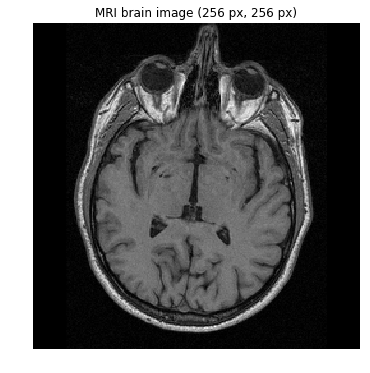

In [2]:
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing
Add your implementation and discussion

In [3]:
import tarfile
import os
import numpy as np
from copy import deepcopy
#import matplotlib.pyplot as plt

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'

import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape


For adding the neighbours, I scan them and mark them in another image to know that I have already pass them, marking the pixels that are in the threshold of intensity with 255, and 128 if they are not. To ease the scanning, I do it sequentially and from top to bottom, and then bottom to top. Each time I add a 1 to the new pizel, I increase the area count.

4


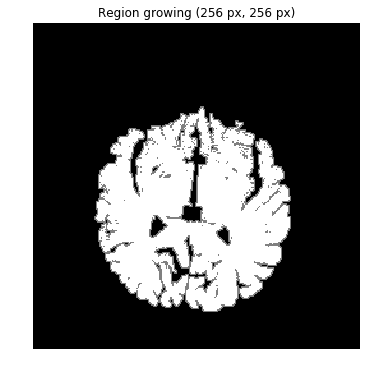

area =  14730


In [4]:
flag01=1;

def add_neighbours(inx, iny):
    flagaux=0;
    for b1 in range(-1, 2):
        for b2 in range(-1, 2):
            if brain_im3[inx+b1, iny+b2] == 0 :
                flagaux=1;
                if brain_im[inx+b1, iny+b2] > (value - th) and brain_im[inx+b1, iny+b2] < (value + th) :
                    brain_im3[inx+b1, iny+b2] = 255
                else:
                    brain_im3[inx+b1, iny+b2] = 128
    return flagaux

                


area=0;
brain_im3 = deepcopy(brain_im);
brain_im3[:] = 0;

value = brain_im[128,64];
value = 80; #tuned with the histogram
th = 18 #threshold
k1 = 30 #border substraction

idx = 160
idy = 180

add_neighbours(idx, idy)
add_neighbours(idx-10, idy-10)# Two seed just in case

count = 0
while flag01 == 1:
    count = count + 1;
    flag01=0;
    
    for a1 in range(1+k1, im_h-k1): #going from top to down, left to right
        for a2 in range(1+k1, im_h-k1):
            if brain_im3[a1,a2] == 255:
                if add_neighbours(a1, a2) == 1:
                    flag01 = 1;

    for a1 in range(im_h-k1-1, 1+k1+1, -1 ): #going from down to top, rigth to left
        for a2 in range(im_h-k1-1, 1+k1+1,-1 ):
            if brain_im3[a1,a2] == 255:
                if add_neighbours(a1, a2) == 1:
                    flag01 = 1;

                    
print(count)# number of iterations
        
for a1 in range(1, im_h):
    for a2 in range(1, im_h):
        if brain_im3[a1,a2] == 255:
            area = area + 1
        
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im3, cmap='gray')
ax.set_title('Region growing ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()     

# for a1 in range(1+k1, im_h-k1):
    # for a2 in range(1+k1, im_h-k1):
        # add_neighbours(a1, a2)

# fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# ax.imshow(brain_im3, cmap='gray')
# ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
# ax.axis('off')
# plt.show() 

print("area = ", area)

### 1.3 Contour detection
Add your implementation and discussion

For this method, I used  combination of 4 filters to consider 4 directions and have better accuracy. I sum the absolute values of the results. 

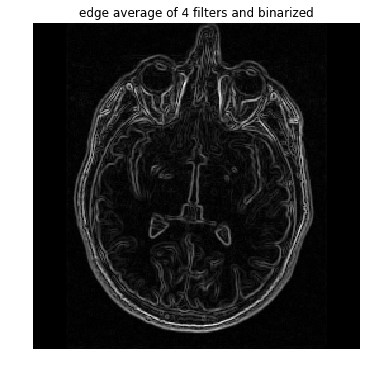

In [5]:
from scipy import signal

h1= [[1,2,1],[0,0,0],[-1,-2,-1]]
#h1= [[-1,-2,-1],[0,0,0],[1,2,1]]
h2= [[0,1,2],[-1,0,1],[-2,-1,0]]
h3= [[-1,0,1],[-2,0,2],[-1,0,1]]
h4= [[2,1,0],[1,0,-1],[0,-1,-2]]

h5= [[2,1,0],[1,0,-1],[0,-1,-2]]

out1 = np.absolute(signal.convolve2d(brain_im,h1))
out2 = np.absolute(signal.convolve2d(brain_im,h2))
out3 = np.absolute(signal.convolve2d(brain_im,h3))
out4 = np.absolute(signal.convolve2d(brain_im,h4))

out = (out1 + out2 + out3 + out4)/4;

# value = 50
# for a1 in range(1, im_h):
    # for a2 in range(1, im_h):
        # if out[a1,a2] > value:
            # out[a1,a2]=255

#out5 = signal.convolve2d(brain_im,h1)


fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(out, cmap='gray')
ax.set_title('edge average of 4 filters and binarized'.format(im_h, im_w))
ax.axis('off')
plt.show() 




After filtering the image, I use a function similar to the one that I used for the increasing region, as it is realy easy toimplemento to scan the area, but in this case the area is added if the value is insade the contour. To be sure that it is still scanning inside the contour, the area is added if the value is lower than the threhold. 

5


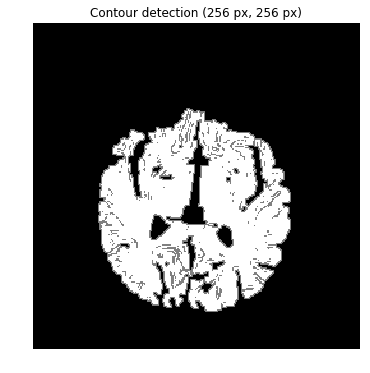

area =  13425


In [6]:
# x1=50
# y1=50
# xh=20
# yh=xh
# np.amax(out)
# fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# ax.imshow(out[x1:x1+xh,y1:y1+yh], cmap='gray')
# ax.set_title('edge average of 4 filters and binarized'.format(xh, yh))
# ax.axis('off')
# plt.show() 

# print(np.amax(out))

brain_im4 = deepcopy(brain_im);
brain_im4[:] = 0;

def add_area_contour(inx, iny): # similar to add_neighbours
    flagaux=0;
    for b1 in range(-1, 2):
        for b2 in range(-1, 2):
            if brain_im4[inx+b1, iny+b2] == 0 :
                flagaux=1;
                if out[inx+b1, iny+b2] < th: #as long it is inside the contour
                    brain_im4[inx+b1, iny+b2] = 255
                else:
                    brain_im4[inx+b1, iny+b2] = 128
    return flagaux


th = 40; #threshold set by testing
k1 = 30 #border substraction

idx = 160
idy = 180

add_area_contour(idx, idy)
add_area_contour(idx-10, idy-10)# Two seed just in case

area = 0
count = 0
flag01=1;
while flag01 == 1: # finding the area inside the contour, similar implementation for making it easy
    count = count + 1;
    flag01=0;
    
    for a1 in range(1+k1, im_h-k1): #going from top to down, left to right
        for a2 in range(1+k1, im_h-k1):
            if brain_im4[a1,a2] == 255:
                if add_area_contour(a1, a2) == 1:
                    flag01 = 1;

    for a1 in range(im_h-k1-1, 1+k1+1, -1 ): #going from down to top, rigth to left
        for a2 in range(im_h-k1-1, 1+k1+1,-1 ):
            if brain_im4[a1,a2] == 255:
                if add_area_contour(a1, a2) == 1:
                    flag01 = 1;

                    
print(count)# number of iterations
        
for a1 in range(1, im_h):
    for a2 in range(1, im_h):
        if brain_im4[a1,a2] == 255:
            area = area + 1
        
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im4, cmap='gray')
ax.set_title('Contour detection ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()  

print("area = ", area)


### 1.4 Additional method(s)
Add your implementation and discussion

As aditional method, I just took a look to the histogram and took at the main concentrations. I took two reasonable values and everything that was in that range. The area for both hills is displayed.

1st method
area =  14086
1st method


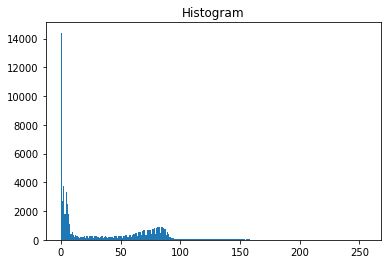

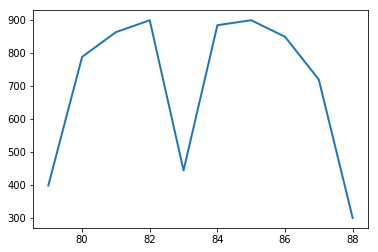

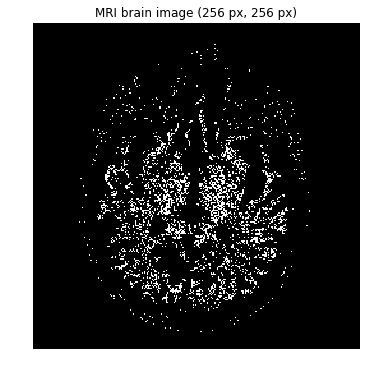

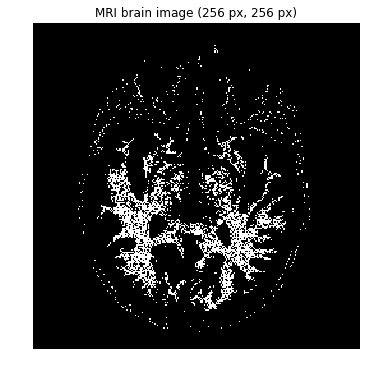

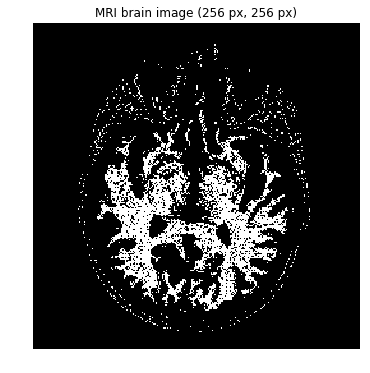

area =  15670


In [7]:
print("1st method")

area=0;
for a1 in range(1, im_h):
    for a2 in range(1, im_h):
        if brain_im[a1,a2] <= 0:
            area = area + 1
print("area = ", area)
      
print("1st method")

area=0;

#plt.hist(brain_im, bins='auto')  # arguments are passed to np.histogram
#plt.title("Histogram with 'auto' bins")
#plt.show()

#h=np.array(plt.hist(brain_im.ravel(),256,[0,256])); 
brain_im1 = deepcopy(brain_im);
brain_im2 = deepcopy(brain_im);
h1=plt.hist(brain_im1.ravel(),256,[0,255]);
plt.title("Histogram")
plt.show()


plt.plot(list(range(79,89)), h1[0][79:89],linewidth=2.0)
#plt.axis([0, 6, 0, 20])
plt.show()  
    
for a1 in range(1, im_h):
    for a2 in range(1, im_h):
        if brain_im[a1,a2] > 78 and brain_im[a1,a2] < 84:
            brain_im1[a1,a2]=255
            area = area + 1
        else :
            brain_im1[a1,a2]=0
        
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im1, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show() 

for a1 in range(1, im_h):
    for a2 in range(1, im_h):
        if brain_im[a1,a2] > 82 and brain_im[a1,a2] < 90:
            brain_im2[a1,a2]=255
            area = area + 1
        else :
            brain_im2[a1,a2]=0
        
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im2, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show() 

for a1 in range(1, im_h):
    for a2 in range(1, im_h):
        if brain_im[a1,a2] > 78 and brain_im[a1,a2] < 90:
            brain_im2[a1,a2]=255
            area = area + 1
        else :
            brain_im2[a1,a2]=0
        
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im2, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show() 

print("area = ", area)

## Part 2: Save the bees !

Varroa mites are recognized as the biggest pest to honey bees worldwide, and are believed to be the single largest contributing factor in the modern-day decline of honey bees due to their ability to transmit diseases, resulting in death or severe deformity of the pupae. 

Detecting and quantifying the presence of Verroa in a beehive is therefore crucial to treat the infection appropriately and as early as possible, and image analysis appears very useful in this problem.

![Varroa Mite](https://lts5www.epfl.ch/wp-content/uploads/2018/07/varroa-2.jpg)



### 2.1 Introduction to Project

You will find hereafter a set of 4 images taken under real conditions. In this task you will be ask to:
1. Count the number of Varroa on each picture
2. Determine the Intersection over Union of the detected patterns w.r.t. the ground truth
3. Estimate the Precision, Recall and F1-score at two different IoU thresholds $T = {0.5 \text{, and } 0.9}$


**Note** 

Try to have the same routine(s) running on the four images, and giving (approximatively) the same results. The routine(s) that you will write for this part will be useful for the final project as well, so pay special attention to it.

#### Vocabulary


* **IoU**: Let $A$ be the ground truth area and $B$ the predicted one. the intersection over union (IoU) is given as:
$$IoU(A,B) = \frac{A \cap B}{A \cup B} = \frac{\text{Area of Overlap}}{\text{Area of Union}}$$
Let $T$ be a scalar in the interval $[0, 1]$, then $B$ will be considered as a true positive (TP) if and only if $IoU(A,B) \ge T$. As a results, we can evaluate the performance of our detection with different values of $T$. The larger $T$ is, the more constraining is our condition.


* **Precision**: The precision is given as:
$$precision = \frac{tp}{tp + fp}$$
where $tp$ is the number of true positives and $fp$ the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.


* **Recall**: The recall is given as:
$$precision = \frac{tp}{tp + fn}$$
where $tp$ is the number of true positives and $fn$ the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.


* **F1-score**: The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
$$F1 = \frac{2 \cdot precision \cdot recall}{precision + recall}$$


**FAQ**

Q: What to do if I have multiple ground truth $A_i$ and candidates $B_j$ and want to find the best set $(i,j)$ such that $(i, j) = \arg\max_{i,j} IoU(A_i, B_j)$ ? 

A: Here, we recommend to use a brute force approach. It corresponds to compute $IoU(A, B)$ for every possible pairs (i,j) and keep the pair with the highest $IoU$. Note that a candidate $B_j$ can **only** be matched to **one** ground truth area $A_i$.

Here, we visualize the 4 images for our patern detection

In [8]:
# Load images
im_names = ['varroa-01', 'varroa-02', 'varroa-03', 'varroa-04']
filenames = [os.path.join(data_path, name) + '.jpg' for name in im_names]
ic = skimage.io.imread_collection(filenames)#,conserve_memory=Fals

print('Number of images: ', len(ic))
print(ic)

Number of images:  4
['..\\data\\lab-01-data\\varroa-01.jpg', '..\\data\\lab-01-data\\varroa-02.jpg', '..\\data\\lab-01-data\\varroa-03.jpg', '..\\data\\lab-01-data\\varroa-04.jpg']


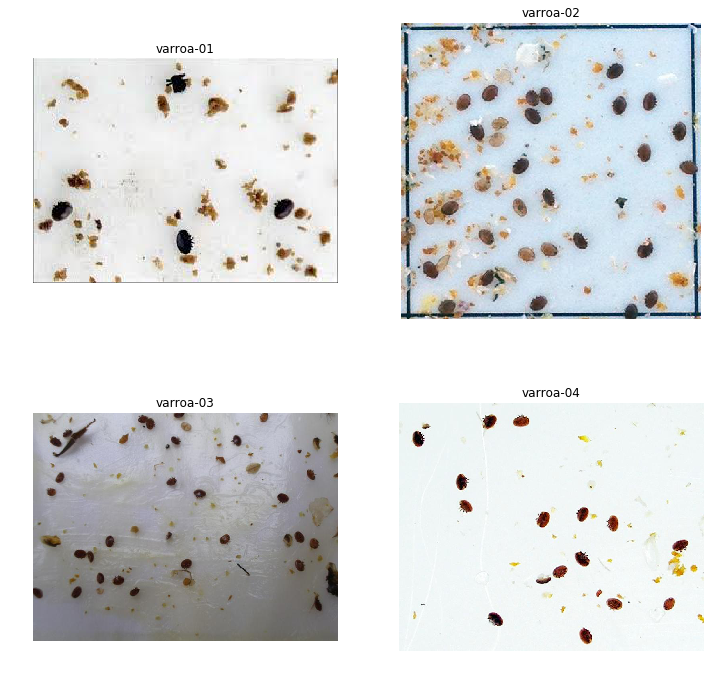

In [9]:
# Plot images
imhs=np.zeros(4,dtype=int)
imws=np.zeros(4,dtype=int)
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
a1=0
for ax, im, nm in zip(axes.ravel(), ic, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
    imhs[a1]=im.shape[0]
    imws[a1]=im.shape[1]
    a1=a1+1
plt.show()



We can as well add the groud truth label that are stored in the corresponding XML files. Each xml file stores the position of the varroa on the image as :

```xml
<annotation>
	<object>
		<name>Varroa</name>
		<difficult>0</difficult>
		<bndbox>
			<xmin>14</xmin>
			<ymin>117</ymin>
			<xmax>33</xmax>
			<ymax>137</ymax>
		</bndbox>
	</object>
	<object>
		...
	</object>
	...
</annotation>
```
The block `object` defines the attributes of the varroa. `name` is the definition of the object class (always varroa). `bndbox` is the definition of the bounding box. To simplify your task, we implemented a function named `parse_file` that returns an array with the bounding box of the varroa expressed as `(x, y, width, heigth)` which corresponds to `(xmin, ymin, xmax-xmin, ymax-ymin)`

In [10]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [11]:
annotations_xmls = [parse_file(os.path.join(data_path, name) + '.xml') for name in im_names]

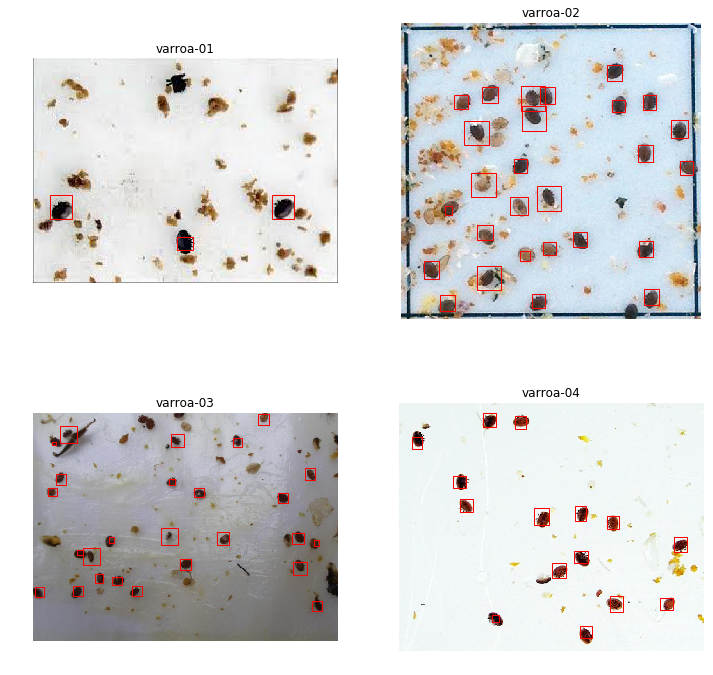

In [12]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm, annotations in zip(axes.ravel(), ic, im_names, annotations_xmls):
    # Iterate over annotations
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Count the number of Varroa on each picture

Add your implementation and discussion

Hint: `skimage.measure.label` might be useful to label the thresholded image

I displayed the histogram of each channel of each image to have an idea of the backgound and filter it.

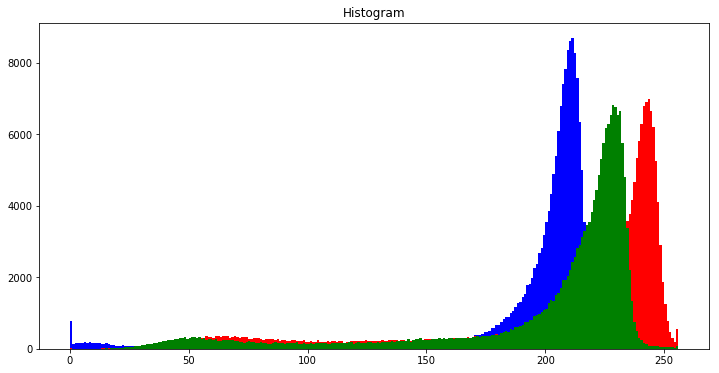

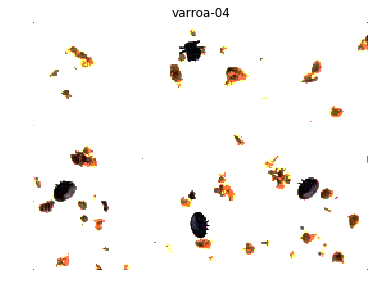

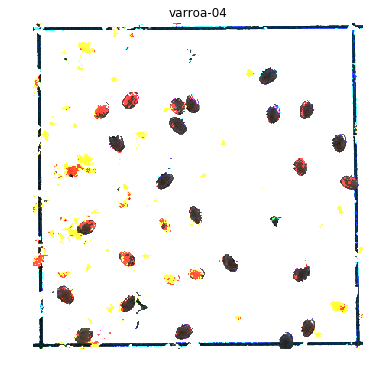

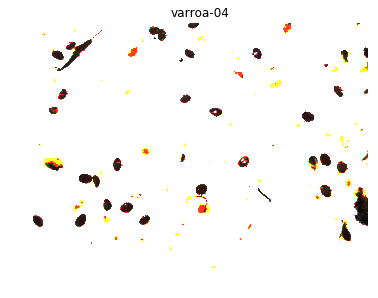

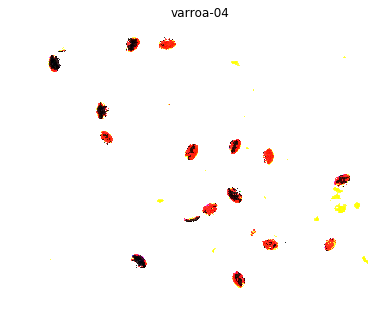

In [13]:
icc = [deepcopy(ic[0]),deepcopy(ic[1]),deepcopy(ic[2]),deepcopy(ic[3])]

icc[0].shape

# fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# ax.imshow(imr1,cmap='gray')
# ax.axis('off')
# #ax.set_title('edge average of 4 filters and binarized'.format(im_h, im_w))
# plt.show() 

# fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# ax.imshow(img1,cmap='gray')
# ax.axis('off')
# #ax.set_title('edge average of 4 filters and binarized'.format(im_h, im_w))
# plt.show() 

# fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# ax.imshow(imb1,cmap='gray')
# ax.axis('off')
# #ax.set_title('edge average of 4 filters and binarized'.format(im_h, im_w))
# plt.show() 

a3=1

plt.subplots(1, 1, figsize=(12, 6))
h=plt.hist(icc[a3][:,:,0].ravel(),256,[0,256],color = 'b');
h=plt.hist(icc[a3][:,:,2].ravel(),256,[0,256],color = 'r');
h=plt.hist(icc[a3][:,:,1].ravel(),256,[0,256],color = 'g');
#plt.axis([0, 180, 0, 2000])
plt.title("Histogram")
plt.show()

for a3 in range (0,4):
    vtop= [140 , 100, 80, 80] #170 values threshold background
    for a1 in range(0, imhs[a3]):
        for a2 in range(0, imws[a3]):
            if ic[a3][a1,a2,0] > vtop[a3] :
                icc[a3][a1,a2,0]=255
            if ic[a3][a1,a2,1] > vtop[a3] :
                icc[a3][a1,a2,1]=255
            if ic[a3][a1,a2,2] > vtop[a3] :
                icc[a3][a1,a2,2]=255



    fig, ax = plt.subplots(1, 1, figsize=(6, 6))    
    ax.imshow(icc[a3])
    ax.axis('off')
    ax.set_title(nm)
    plt.show()



I created a copy to not run everything again and work by segments without losing information. I set a threshold for each channel for each image to binarize them. 

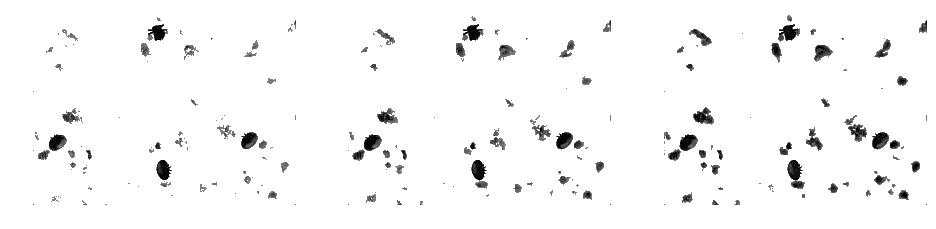

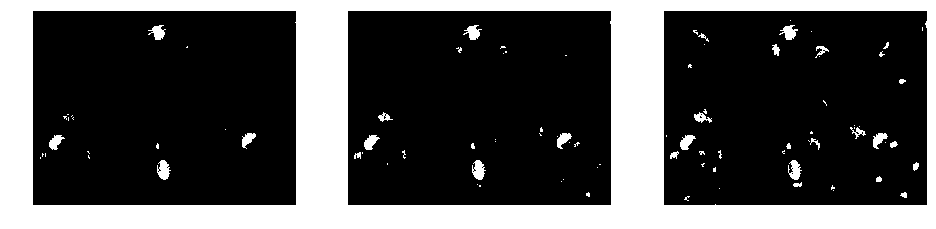

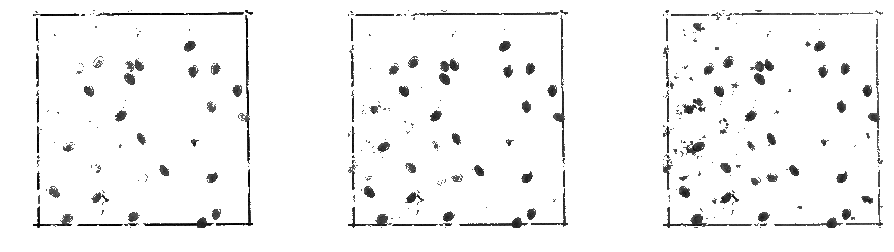

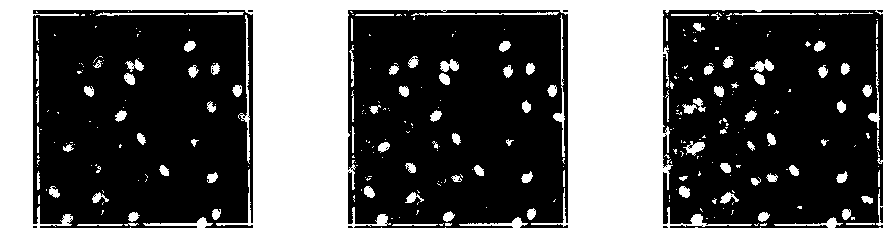

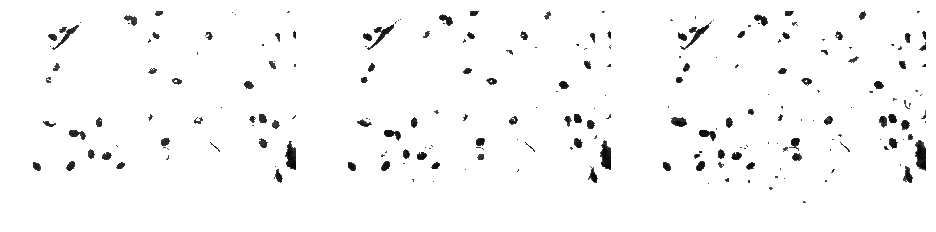

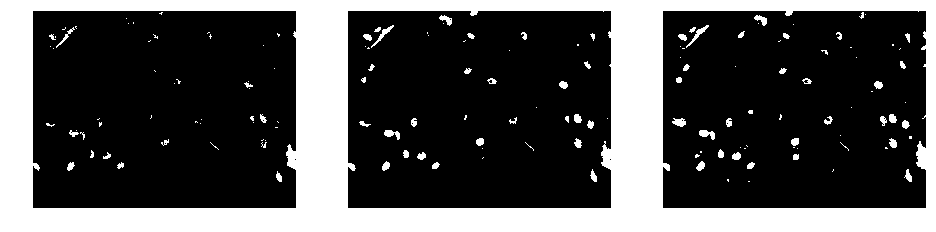

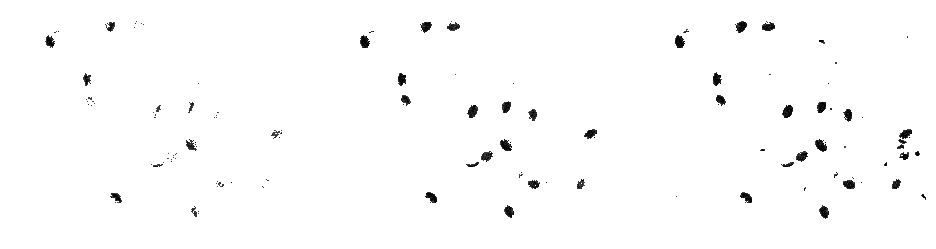

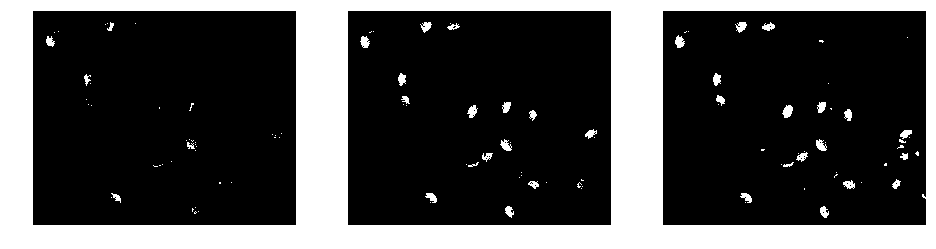

In [14]:
icc2=deepcopy(icc)

for a3 in range (0,4):

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    a1=0
    for ax in axes.ravel():
        ax.imshow(icc[a3][:,:,a1],cmap='gray')
        ax.axis('off')
        a1+=1
    plt.show()



    th=[[50,50,50],[100, 100, 100],[50,50,50],[50,50,50]]

    #for a3 in range(0, 4):
    for a1 in range(0, imhs[a3]):
        for a2 in range(0, imws[a3]):
            if icc[a3][a1,a2,0] < th[a3][0] :
                icc2[a3][a1,a2,0]=255
            else:
                icc2[a3][a1,a2,0]=0
            if icc[a3][a1,a2,1] < th[a3][1] :
                icc2[a3][a1,a2,1]=255
            else:
                icc2[a3][a1,a2,1]=0
            if icc[a3][a1,a2,2] < th[a3][2] :
                icc2[a3][a1,a2,2]=255
            else:
                icc2[a3][a1,a2,2]=0

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    a1=0 
    for ax in axes.ravel():
        ax.imshow(icc2[a3][:,:,a1],cmap='gray')
        ax.axis('off')
        a1+=1
    plt.show()

I add all of the binarized images at the slot of the first channel, and maintein the other two channels, because I wanted to test them by themselves but I did not have enough time. 

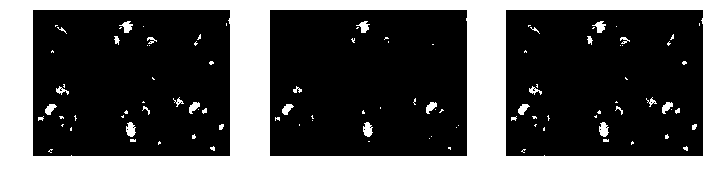

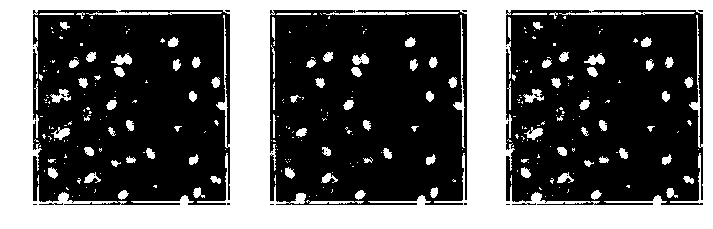

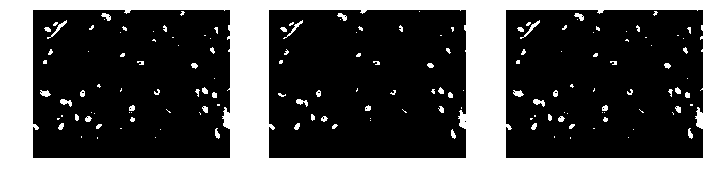

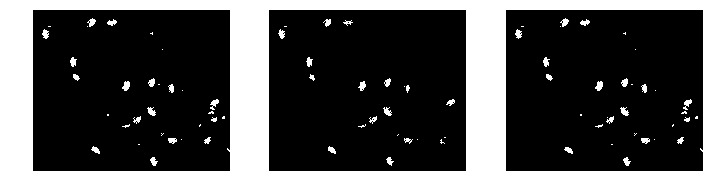

In [23]:
icc3=deepcopy(icc2)

for a3 in range(0, 4):

    for a1 in range(0, imhs[a3]):
        for a2 in range(0, imws[a3]):
            if icc[a3][a1,a2,0] < th[a3][0] :
                icc3[a3][a1,a2,0]=255
                icc3[a3][a1,a2,1]=255
                icc3[a3][a1,a2,2]=255
            else :
                if icc[a3][a1,a2,1] < th[a3][1] :
                    icc3[a3][a1,a2,1]=255
                else:
                    icc3[a3][a1,a2,1]=0
                if icc[a3][a1,a2,2] < th[a3][2] :
                    icc3[a3][a1,a2,2]=255
                else:
                    icc3[a3][a1,a2,2]=0
                if icc[a3][a1,a2,1] < th[a3][1] or icc[a3][a1,a2,2] < th[a3][2] :
                    icc3[a3][a1,a2,0]=255
                else:
                    icc3[a3][a1,a2,0]=0

    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    a1=0 
    for ax in axes.ravel():
        ax.imshow(icc3[a3][:,:,a1],cmap='gray')
        ax.axis('off')
        a1+=1
    plt.show()



Definitions for erosion, dilation, closing and opening. For every image, I do a closing of 3 pixels, and an opening of 5. This values could be adjusted for each case to have better performance, as every threshold mentioned.

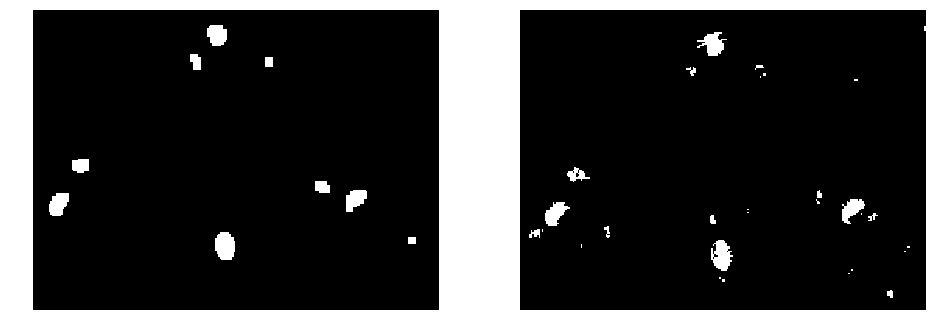

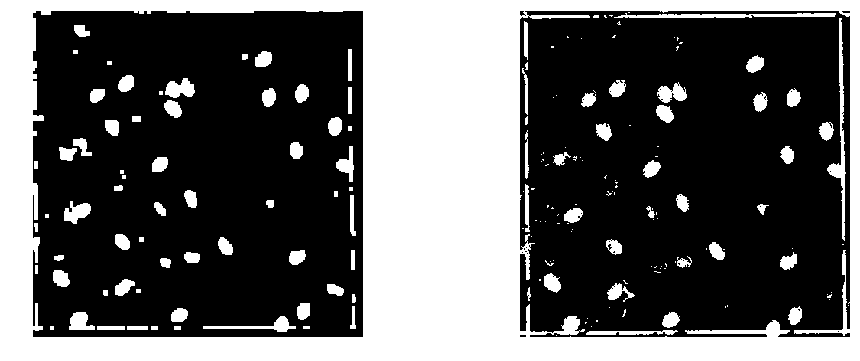

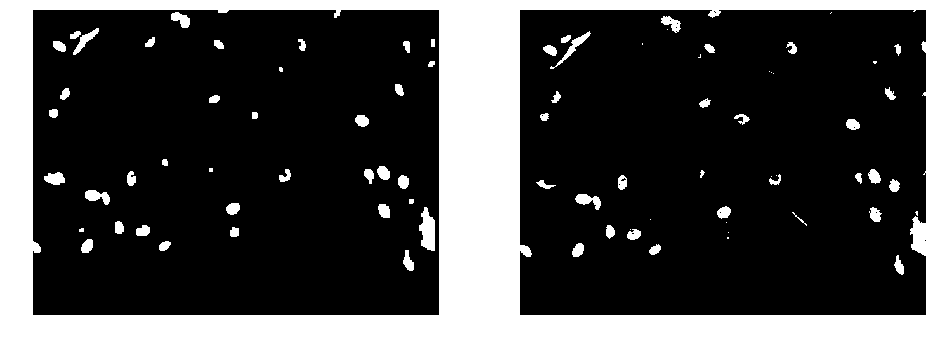

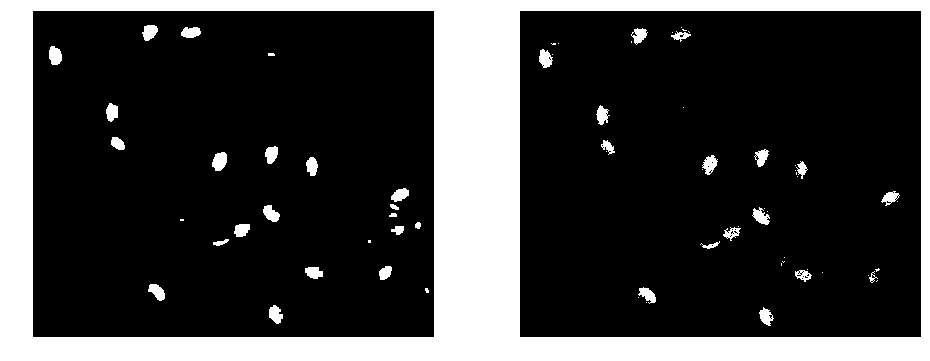

In [16]:
icc4=deepcopy(icc3)

def erode(n,im,imh,imw): # similar to add_neighbours
    for b1 in range(0, imh-n):
        for b2 in range(0, imw-n):
            flagaux=255
            for b3 in range(0, n):
                for b4 in range(0, n):
                    if im[b1+b3, b2+b4] == 0 :
                        flagaux = 0;
                        break
                if flagaux == 0 :
                    break
            im[b1, b2]=flagaux;
    for b1 in range(imh-n, imh):
        for b2 in range(0,imw):
            im[b1, b2] = 0
    for b1 in range(0, imh):
        for b2 in range(imw-n,imw):
            im[b1, b2] = 0
            
def dilate(n,im,imh,imw): # similar to add_neighbours
    for b1 in range(0, imh-n):
        for b2 in range(0, imw-n):
            flagaux=0
            for b3 in range(0, n):
                for b4 in range(0, n):
                    if im[b1+b3, b2+b4] != 0 :
                        flagaux = 255;
#                        break
#                    if flagaux == 255 == 1 :
#                    break
            im[b1, b2]=flagaux;
    
def opening(n,im,imh,imw): # similar to add_neighbours
    erode(n,im,imh,imw)
    dilate(n,im,imh,imw)
def closing(n,im,imh,imw): # similar to add_neighbours
    dilate(n,im,imh,imw)
    erode(n,im,imh,imw)
    

for a3 in range(0, 4):   
    #closing(3,icc4[a3][:,:,2],imhs[a3],imws[a3])
    #opening(5,icc4[a3][:,:,2],imhs[a3],imws[a3])

    #closing(3,icc4[a3][:,:,1],imhs[a3],imws[a3])
    #opening(5,icc4[a3][:,:,1],imhs[a3],imws[a3])
    
    closing(3,icc4[a3][:,:,0],imhs[a3],imws[a3])
    opening(5,icc4[a3][:,:,0],imhs[a3],imws[a3])
    #closing(3,icc4[a3][:,:,0],imhs[a3],imws[a3])

    #erode(3,icc4[a3][:,:,2],imhs[a3],imws[a3])
    #dilate(6,icc4[a3][:,:,2],imhs[a3],imws[a3])

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    a1=0 
    for ax in axes.ravel():
        ax.imshow(icc4[a3][:,:,a1],cmap='gray')
        ax.axis('off')
        a1+=1
    plt.show()

To count the objects in the image, I scan every pixel of the image, and when a 1 was found, it was checked that it wasn't marked yet in another image created to have register of the objects(objs). If the pixel has not been marked yet, the area was analized using again a method similar to the increasing region. While doing this, the area was counted, and the minimum and maximum x and y were recorded. After the object was marked, the scan progesses. If the area is not big enough, the object is not considered.

9


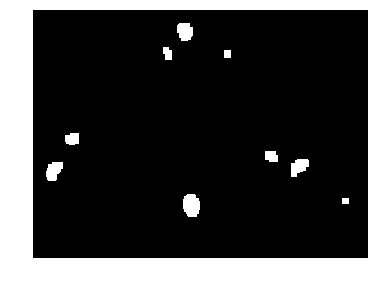

77


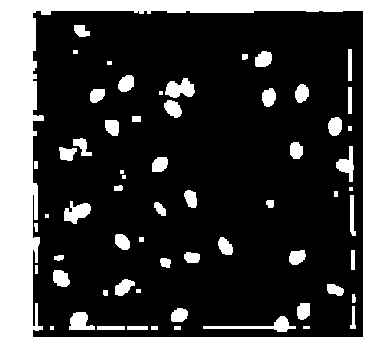

40


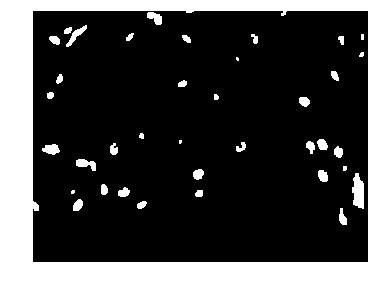

24


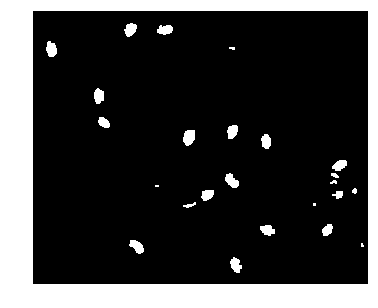

In [17]:
icc5=deepcopy(icc4)


def add_area_obj_d(inx, iny, im, obs): 
    flagaux=0;
    for b1 in range(-1, 2):
        for b2 in range(0, 2):#only going down
            if im[inx+b1, iny+b2] != 0 and obs[inx+b1, iny+b2] == 0:
                flagaux=1;
                obs[inx+b1, iny+b2] = 255
                areas[a3,count]+=1;
                
                if maxy[a3,count]<iny+b2:
                    maxy[a3,count]=iny+b2
                if miny[a3,count]>iny+b2:
                    miny[a3,count]=iny+b2
                if maxx[a3,count]<inx+b1:
                    maxx[a3,count]=inx+b1
                if minx[a3,count]>inx+b1:
                    minx[a3,count]=inx+b1         

    return flagaux


def add_area_obj_u(inx, iny, im, obs): 
    flagaux=0;
    for b1 in range(-1, 2):
        for b2 in range(-1, 1):#only going up
            if im[inx+b1, iny+b2] != 0 and obs[inx+b1, iny+b2] == 0:
                flagaux=1;
                obs[inx+b1, iny+b2] = 255
                areas[a3,count]+=1;
                
                if maxy[a3,count]<iny+b2:
                    maxy[a3,count]=iny+b2
                if miny[a3,count]>iny+b2:
                    miny[a3,count]=iny+b2
                if maxx[a3,count]<inx+b1:
                    maxx[a3,count]=inx+b1
                if minx[a3,count]>inx+b1:
                    minx[a3,count]=inx+b1
    return flagaux

def analize(inx,iny,im,obs,imh,imw):
    area = 0
    flag01=1;
    while flag01 == 1: # finding the area inside the contour, similar implementation for making it easy
        flag01=0;
        for b1 in range(1, imh-1): #going from top to down, left to right
            for b2 in range(1, imw-1):
                if obs[b1,b2] != 0:
                    if add_area_obj_d(b1,b2,im,obs) == 1:
                        flag01 = 1;

        for b1 in range(imh-1, 1, -1 ): #going from down to top, rigth to left
            for b2 in range(imw-1, 1,-1 ):
                if obs[b1,b2] != 0:
                    if add_area_obj_u(b1,b2,im,obs) == 1:
                        flag01 = 1;

 
k1=100
areas = np.zeros((4,k1),dtype=int)
counts = np.zeros((4),dtype=int)
maxy=np.zeros((4,k1),dtype=int)
maxx=np.zeros((4,k1),dtype=int)
miny=np.ones((4,k1),dtype=int)+200000
minx=np.ones((4,k1),dtype=int)+200000

for a3 in range(0, 4): 

    objs = np.zeros((imhs[a3],imws[a3]),dtype=int)
    count = 0;
    


    for a1 in range(0, imhs[a3]):
        for a2 in range(0, imws[a3]):
            if icc5[a3][a1,a2,0] != 0 :
                if objs[a1,a2] == 0:
                    #print(count)
                    objs[a1,a2]=255;
                    analize(a1,a2,icc5[a3][:,:,0],objs,imhs[a3],imws[a3])
                    if areas[a3,count] > 20 :                  
                        count+=1;
                    else:
                        areas[a3,count] = 0
                        maxy[a3,count]=0
                        miny[a3,count]=20000
                        maxx[a3,count]=0
                        minx[a3,count]=20000                        
                    #print(maxy[count],maxx[count],miny[count],minx[count])
                    #print(areas[count])
                    #break                
    counts[a3]=count
    print(count)

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))    
    ax.imshow(objs, cmap='gray')
    ax.axis('off')
    plt.show()

Now we have the area and the dimension, so, to classify, I used the area and the division between the width and height to discriminate the objects, and count them

In [18]:
areas2 = deepcopy(areas)
counts2 = deepcopy(counts)
maxy2=deepcopy(maxy)
maxx2=deepcopy(maxx)
miny2=deepcopy(miny)
minx2=deepcopy(minx)

count = 0;
thsa_h=[210, 600, 400, 800] #area threshold up
thsa_l=[130, 150, 100, 400] #area threshold down
for a3 in range(0, 4): 
    count = 0;
    for a4 in range (0,k1):
        if areas2[a3,a4] > thsa_l[a3] and areas2[a3,a4] < thsa_h[a3] :
            aux = (maxy2[a3,a4]-miny[a3,a4])/(maxx2[a3,a4]-minx[a3,a4]) #division h/w
            if aux >0.5 and aux < 2 :
                #print(areas2[a3,a4],maxy2[a3,count],maxx2[a3,count])
                areas2[a3,count]=areas2[a3,a4]
                maxy2[a3,count]=maxy2[a3,a4]
                maxx2[a3,count]=maxx2[a3,a4]
                miny2[a3,count]=miny2[a3,a4]
                minx2[a3,count]=minx2[a3,a4]
                count += 1;
    counts[a3] = count
    print ("verroa ",a3+1,": ",count)
  

verroa  0 :  4
verroa  1 :  26
verroa  2 :  25
verroa  3 :  15


### 2.3 IoU of the detected pattern w.r.t. the ground truth

Add your implementation and discussion

Hint: `skimage.measure.regionprops` implements a large variety of descriptors

For the IOU, the minimum of the maximums, and the maximum of the minimums were considered to intersection area, unless they are not touching in which case it returns zero. The union area will be the area of both added minus the intersection. I used an offset to adjust the place of the object as the opening and closings modified the position. The rectangles printed are my rectangles.

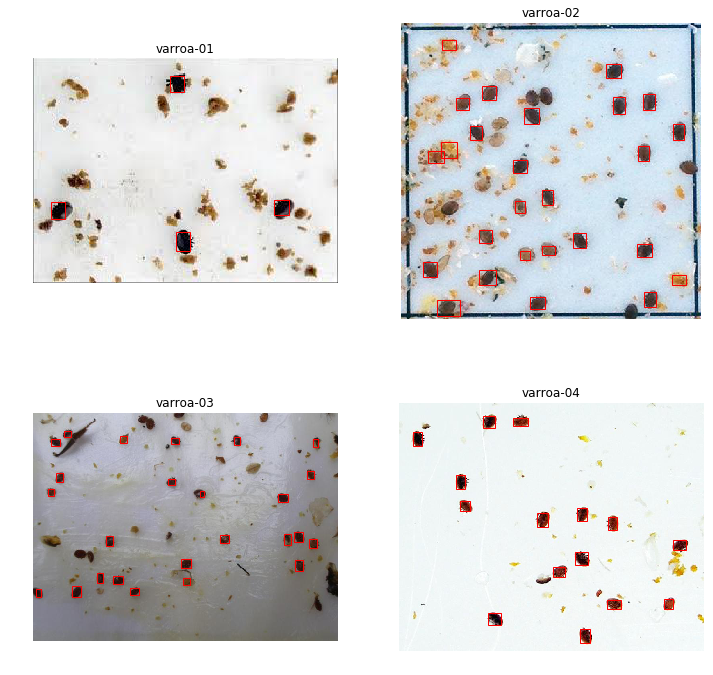

In [19]:
def iou(xmi1, ymi1, xma1, yma1, xmi2, ymi2, xma2, yma2):
    if xma1 < xmi2 or xma2 < xmi1:#not touching condition
        return 0;
    if yma1 < ymi2 or yma2 < ymi1:#not touching condition
        return 0; 
    
    area1=(xma1-xmi1)*(yma1-ymi1);
    area2=(xma2-xmi2)*(yma2-ymi2);
    
    ya=0;
    if yma1 > yma2:
        yam=yma2
    else:
        yam=yma1
        
    if xmi1 < xmi2:
        xim=xmi2
    else:
        xim=xmi1
        
    if ymi1 < ymi2:
        yim=ymi2
    else:
        yim=ymi1
        
    if xma1 > xma2:
        xam=xma2
    else:
        xam=xma1

    areai = (xam-xim)*(yam-yim);
    areau = area1+area2-areai;
    return areai/areau
    


fig, axes = plt.subplots(2, 2, figsize=(12, 12))

offset = 5

for ax, im, nm, a3 in zip(axes.ravel(), ic, im_names, range(0,4)):
    # Iterate over annotations
    for a4 in range (0,counts[a3]):
        rect = patches.Rectangle((miny2[a3,a4]+offset, minx2[a3,a4]+offset), maxy2[a3,a4]-miny2[a3,a4], maxx2[a3,a4]-minx2[a3,a4],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

accumulator = 0
aux01=0
aux02=0
ious=np.zeros((4,max(counts)))

for a3 in range(0,4):
    for a4 in range (0,counts[a3]):
        for anno in annotations_xmls[a3]:
            #print(miny2[a3,a4]+offset, minx2[a3,a4]+offset, maxy2[a3,a4]+offset,maxx2[a3,a4]+offset,anno['bbox'][0], anno['bbox'][1], anno['bbox'][2]+anno['bbox'][0], anno['bbox'][3]+anno['bbox'][1])
            aux01=iou(miny2[a3,a4]+offset, minx2[a3,a4]+offset, maxy2[a3,a4]+offset,maxx2[a3,a4]+offset,anno['bbox'][0], anno['bbox'][1], anno['bbox'][2]+anno['bbox'][0], anno['bbox'][3]+anno['bbox'][1])
            if aux02<aux01:
                aux02=aux01
        #print (aux02)
        ious[a3,a4]=aux02;
        aux02=0
#print(ious)        


### 2.4 Precision, Recall and F1-score at two different IoU thresholds

Add your implementation and discussion

The results are printed, varying T from 0.5 to 0.9, with a step of 0.05. 

In [27]:
def TP (iouin,T):
    if iouin < T :
        return 0
    else:
        return 1
    
def precision (ntp,nfp):
    if ntp != 0 :
        return ntp/(ntp+nfp)
    else:
        return 0
    
def recall (ntp,nfn):
    if ntp != 0 :
        return ntp/(ntp+nfn)
    else:
        return 0

def F1 (ntp,nfp,nfn):
    if ntp != 0  :
        return (2*precision (ntp,nfp)+recall (ntp,nfn))/(precision (ntp,nfp)+recall (ntp,nfn))
    else:
        return 0
acc0=0;
acc1=0;
accf0=0;
for T in np.arange (0.5,0.9,0.05):
    print("T: ",T)
    for a3 in range(0,4):
        acc0=0;
        acc1=0;
        accf0+=0;
        for a4 in range (0,counts[a3]):
            if ious[a3,a4] == 0.0 :
                accf0+=1; #false positive, no overlaping, so not existant
            elif TP (ious[a3,a4],T) :
                acc1+=1; #true positives
            else:
                acc0+=1; #false negatives , correct but wrongly classified
            #print (aux02)
        print ("im",a3+1," precision: ",precision(acc1,accf0)," recall: ",recall(acc1,acc0),"F1-score: ",F1(acc1,accf0,acc0))

T:  0.5
im 1  precision:  0.5  recall:  0.3333333333333333 F1-score:  1.6
im 2  precision:  0.7619047619047619  recall:  0.7272727272727273 F1-score:  1.5116279069767442
im 3  precision:  0.4375  recall:  0.3333333333333333 F1-score:  1.5675675675675675
im 4  precision:  0.5909090909090909  recall:  0.8666666666666667 F1-score:  1.4054054054054057
T:  0.55
im 1  precision:  0  recall:  0 F1-score:  0
im 2  precision:  0.48148148148148145  recall:  0.5909090909090909 F1-score:  1.4489795918367345
im 3  precision:  0.28  recall:  0.3333333333333333 F1-score:  1.4565217391304348
im 4  precision:  0.3333333333333333  recall:  0.6 F1-score:  1.357142857142857
T:  0.6000000000000001
im 1  precision:  0  recall:  0 F1-score:  0
im 2  precision:  0.3611111111111111  recall:  0.5909090909090909 F1-score:  1.3793103448275863
im 3  precision:  0.20588235294117646  recall:  0.3333333333333333 F1-score:  1.3818181818181818
im 4  precision:  0.20588235294117646  recall:  0.4666666666666667 F1-score:

As it can be seen the presition of the test goes down as the restrictiveness increases. It would be almost impossible to match the exact area of the truth with these methods. The result are not good in general, as the areas are quite different, although the recognition was not that bad. The results could be improved by tunning the tresholds, adding filtering for taking advantage of the contours, adding other descriptors, and using the same format ilumination , camera , and setting for taking the pictures.